<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from catboost import cv, Pool
import os

SEED = 41

In [4]:

local_path = '../datasets/taxi.csv'
cloud_path = '/datasets/taxi.csv'

if os.path.exists(local_path):
    df = pd.read_csv(local_path, parse_dates=['datetime'], index_col='datetime')
elif os.path.exists(cloud_path):
    df = pd.read_csv(cloud_path, parse_dates=['datetime'], index_col='datetime')
else:
    print('Something is wrong!')

# Проверим хронологичность временных данных.

print('Ok, dataset is monotonic.' if df.index.is_monotonic 
      else 'Be careful, dataset is not monotonic!!')



Ok, dataset is monotonic.


In [5]:
df

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]

In [3]:
# Производим семплирование к 1 часу.
df = df.resample('1H').sum()

# Проверяем результат
df

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]

In [4]:
def make_features(data:pd.DataFrame, 
                  max_lag=0, 
                  rolling_size=0):
    '''
    Make extra features to time series predictions.
    Args:
        data (pandas.DataFrame): dataset to add extra columns
        max_lag (int): num of columns with shifted data
        rolling_size (int): window size for rolling mean and rolling std
    
    '''
    data.loc[:,'day'] = data.index.day  # day feature
    data.loc[:,'dayofweek'] = data.index.dayofweek # dayofweek feature
    data.loc[:,'hour'] = data.index.hour # hour feature
    if max_lag:
        for lag in range(1, max_lag + 1):
            data.loc[:,'lag_{}'.format(lag)] = data['num_orders'].shift(lag) # making columns with n shifted data
    if rolling_size:
        data.loc[:,'rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean() # add rolling mean column
        data.loc[:, 'rolling_std'] = data['num_orders'].shift().rolling(rolling_size).std() # add rolling std column
    return data

## Анализ

In [5]:
def seasonal_plot(data:pd.DataFrame, 
                  date_from:str, 
                  date_till:str, 
                  window_size=24, 
                  return_back=False
                 ):
    '''
    Function to plot mean, std, trend, seasonal and remains
    
    Args:
        data (pandas.DataFrame): dataset to aggregate
        date_from (str): start date to makeing cut, format year-month-day
        date_till (str): end date to makeing cut, format year-month-day
        window_size (int): vlue to rolling mean calculate
        return_back (bool): if need to return data with trend, seasonal and resid. default 'False'
    '''

    sbs = data[date_from:date_till] # making subset of data: from date:till_date
    
    plt.figure(figsize=(15,8))
    rolling = sbs.rolling(window_size).mean() # calc rolling mean
    std = sbs.rolling(window_size).std() # calc rolling std
    sns.lineplot(data=sbs, x='datetime', y='num_orders', label='raw_data', alpha=0.6)
    sns.lineplot(data=rolling, x='datetime', y='num_orders', label='rolling_mean')
    sns.lineplot(data=std, x='datetime', y='num_orders', label='std');
    
    seasonal_sbs = seasonal_decompose(sbs) 
    plt.figure(figsize=(15, 8))
    plt.subplot(311)
    seasonal_sbs.trend.plot(ax=plt.gca())
    plt.title('Trend')

    plt.subplot(312)
    seasonal_sbs.seasonal.plot(ax=plt.gca())
    plt.title('Seasonal')

    plt.subplot(313)
    seasonal_sbs.resid.plot(ax=plt.gca())
    plt.title('Resid')

    plt.tight_layout(); # feature to correct view
    
    if return_back:
        return seasonal_sbs

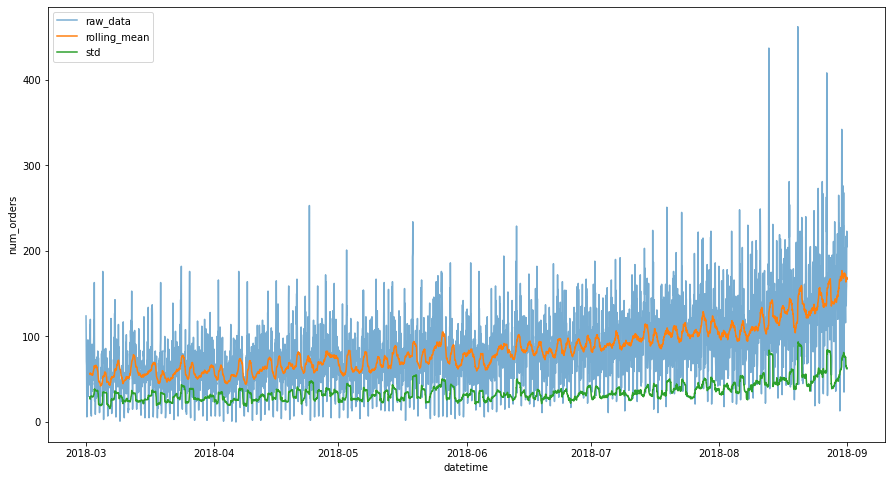

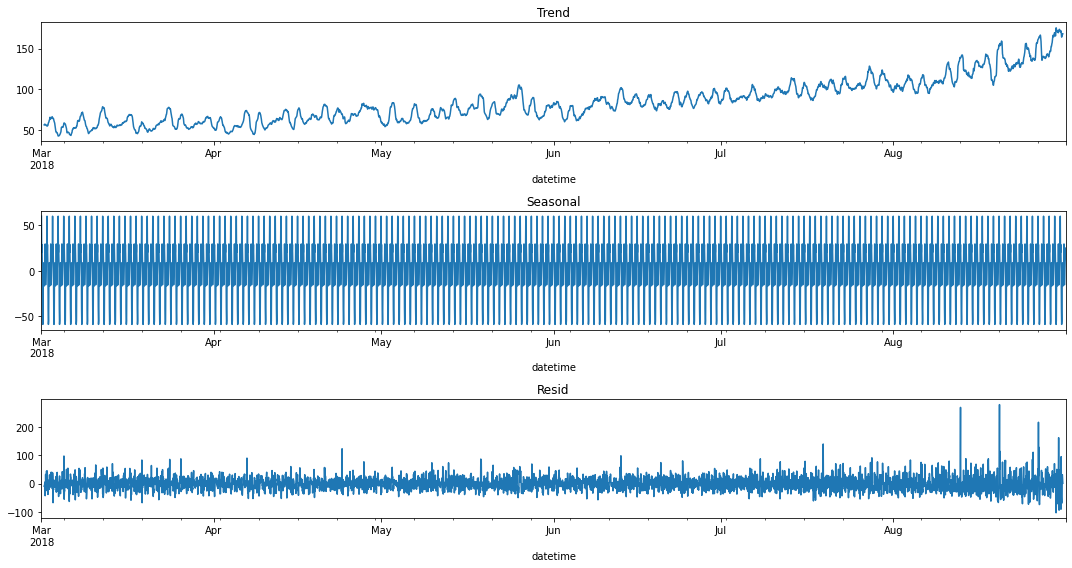

In [6]:
# Псотроим графики по всем данным: Скользящее среднее, скользязее стандартное отклонение, тренд, сезонность, шум.
seasonal_plot(df, '2018-01', '2018-08', 24)

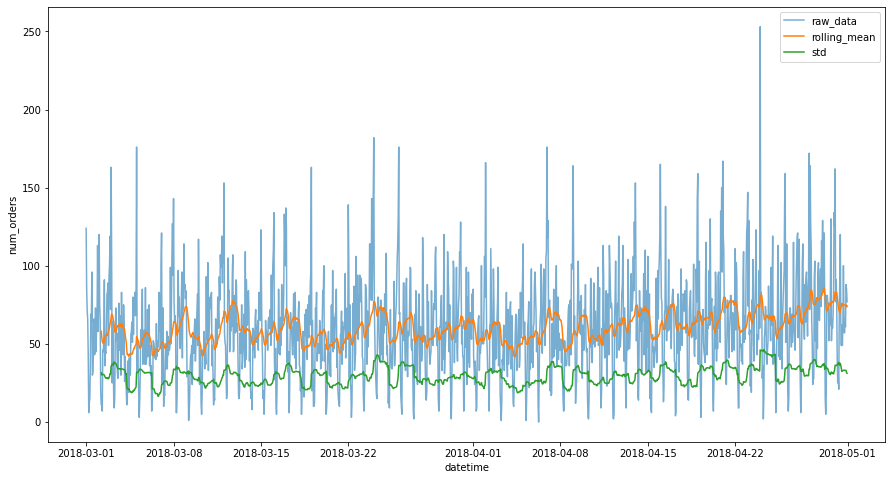

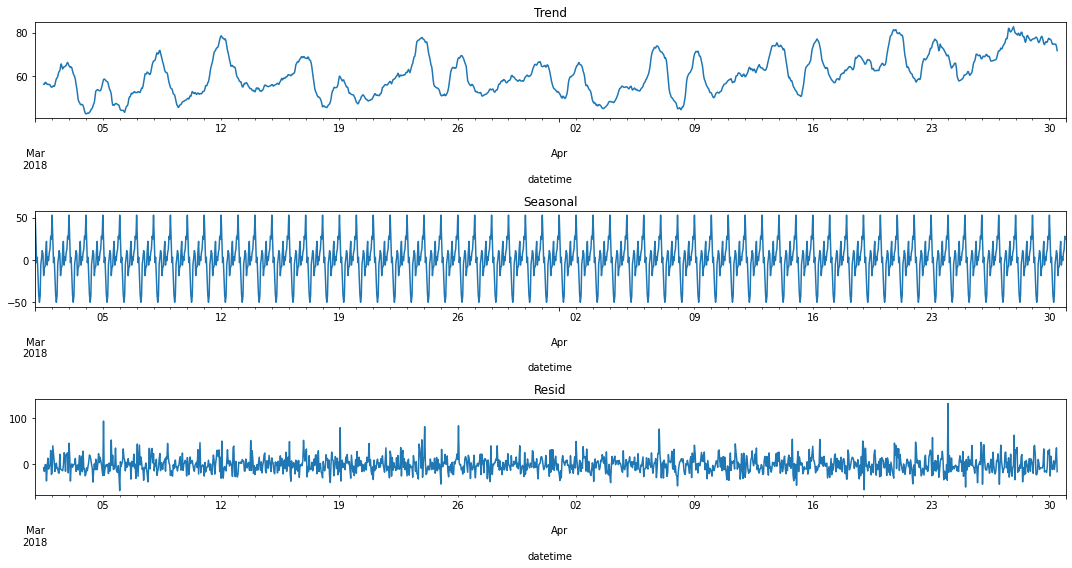

In [7]:
# Теперь проанализируем те же данные на отрезке месяца

seasonal_plot(df, '2018-03', '2018-04', window_size=30)

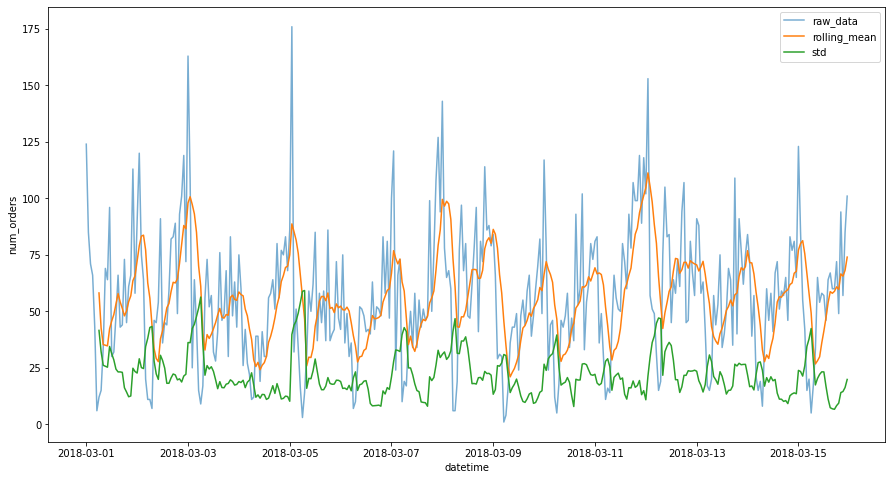

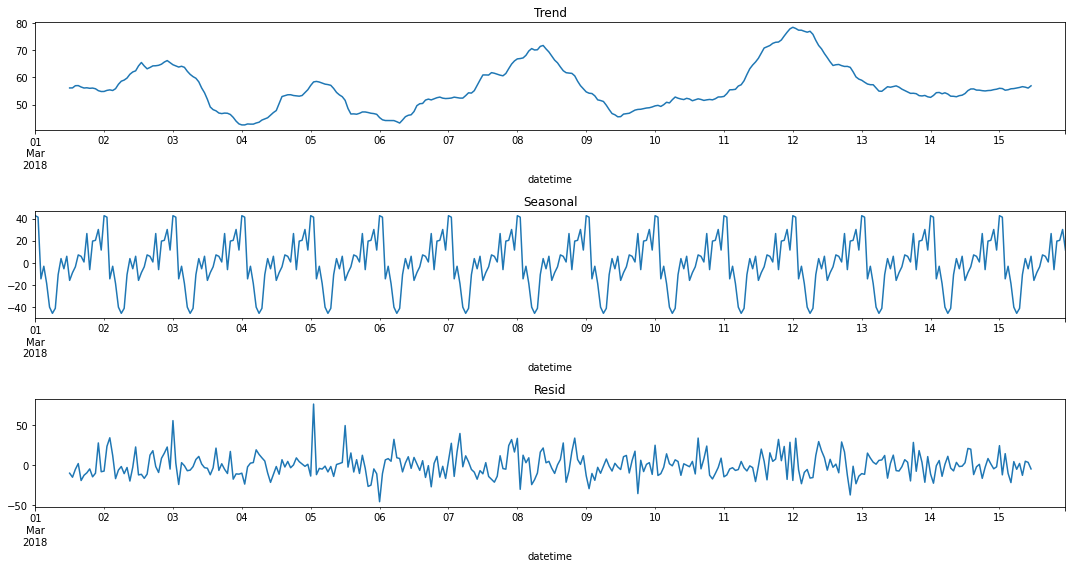

In [8]:
# И то же самое на недельном отрезке 

seasonal_plot(df, '2018-03-01', '2018-03-15', window_size=7)

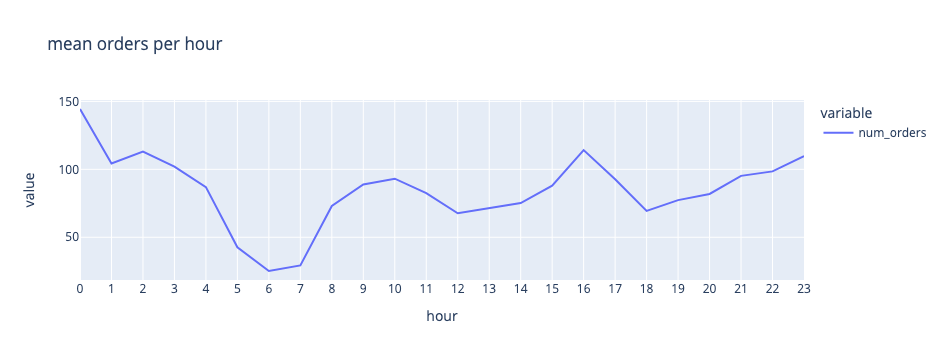

In [9]:
# Более подробные и интерактивные графики сезонности внутри дня и внутри недели
df = make_features(df)
hour_grouped = df.groupby('hour')['num_orders'].mean()
fig = px.line(hour_grouped, title='mean orders per hour')

fig.update_xaxes(
    dtick="H1")
fig.update_layout(
    xaxis_tickformat="%H:%M")

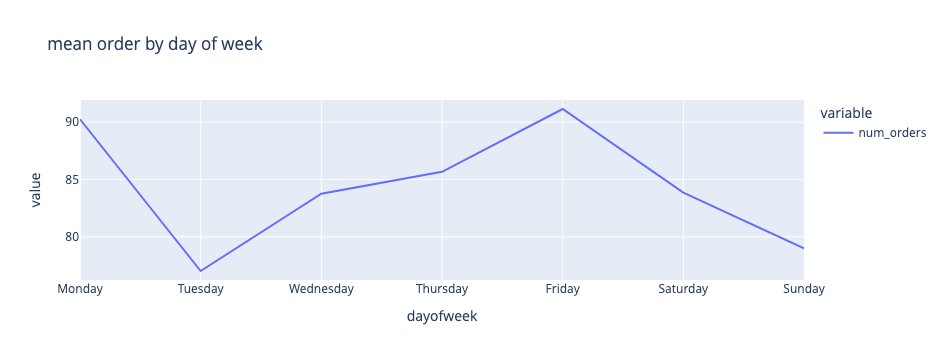

In [10]:
week_grouped = df.groupby('dayofweek')['num_orders'].mean()

fig = px.line(week_grouped, title='mean order by day of week')

fig.update_layout(
    xaxis = dict(
        tickvals = np.arange(0,7,1),
        ticktext = ['Monday',
                    'Tuesday',
                    'Wednesday',
                    'Thursday',
                    'Friday',
                    'Saturday',
                    'Sunday']
    )
)


In [11]:
# Тест Дики-Фуллера для проверки на стационарность ряда

result = adfuller(df['num_orders'], autolag='AIC')

print(f'Критерий ADF: {result[0]:.5f}')
print(f'P-value: {result[1]:.5f}')

for key, value in result[4].items():
    print(f'\t{key, value}')
    if result[0] < result[4]["5%"]:
        print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
    else:
        print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.06892
P-value: 0.02894
	('1%', -3.431842162413052)
Нулевая гипотеза отвергнута – Временной ряд стационарен
	('5%', -2.8621993540813637)
Нулевая гипотеза отвергнута – Временной ряд стационарен
	('10%', -2.567120978470452)
Нулевая гипотеза отвергнута – Временной ряд стационарен


### Вывод:
- Видим устойчивый тренд на общее увеличение кол-ва заказов к концу изучаемоего периода (август). 
- Хорошо прослеживается сезонность в масштабе недели, также внутри дня по часам. 
- На основе теста Дики-Фуллера отвергнута нулевая гипотеза о нестационарности временного ряда => временной ряд стационарен

## Обучение

In [35]:
def evaluate(model, 
             train_features,
             train_target, 
             test_features,
             test_target,
             return_predictions=False, 
             target_feature_name='num_orders',
            n_splits=6
            ):
    '''
    This function get fitted model, train and test features, targets, 
    split data into k-folds to make timeseries cross-validation
    and return mean cv-score.
        
    return_prediction: if needed to get predictions values 
    '''
    X = train_features
    y = train_target
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = {}
    for i, (train_idx, valid_idx) in enumerate(tscv.split(X)):
#         print("TRAIN:", train_idx, "TEST:", valid_idx)
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        model.fit(X_train, y_train)
        fold_predictions = model.predict(X_valid)
        scores[i] = mean_squared_error(y_valid, fold_predictions, squared=False)
    mean_score = sum(scores.values()) / len(scores)
    print(f"mean train RMSE: {mean_score}")
    
    print(f"train RMSE by each fold: {scores}")
    test_predictions = model.predict(test_features)
    test_RMSE = mean_squared_error(test_target, test_predictions, squared=False)
    print(f"test RMSE: {test_RMSE}")
    
    
    
    
    if return_predictions:
        return test_predictions

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



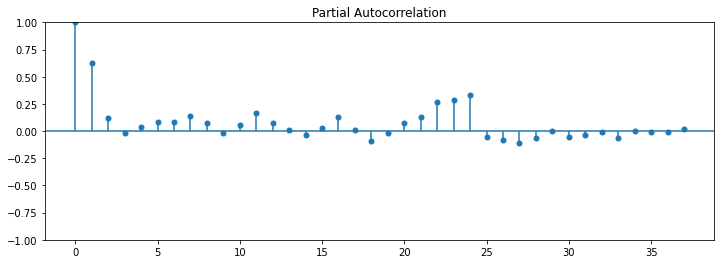

In [36]:
# Частичная автокорреляция для выбора порядка авторегрессии
plot_pacf(df['num_orders'], alpha=None).set_size_inches(12, 4)
plt.show()

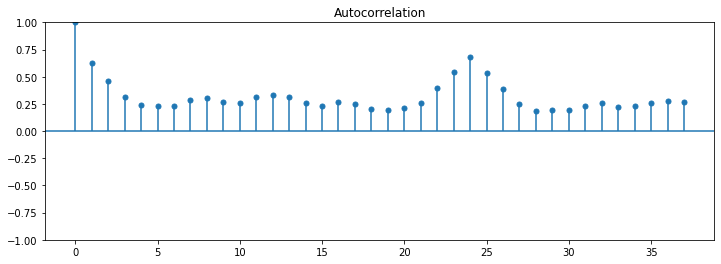

In [37]:
# График автокорреляци для определения порядка скользящего среднего. 
plot_acf(df['num_orders'], alpha=None).set_size_inches(12, 4)
plt.show()

In [38]:
# Разделение на train и test
tscv = TimeSeriesSplit()

df = make_features(df, 
                   max_lag=24, 
                   rolling_size=26
                  )
df = df.dropna()

X = df.drop(columns='num_orders')
y = df['num_orders']


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.1,
                                                    shuffle=False,
                                                   random_state=SEED)


In [39]:
# Проверка модели на вменяемость 

test_shifted = y_test.shift()
test_shifted.iloc[0] = y_train.iloc[-1]

mean_squared_error(y_test, test_shifted, squared=False)


59.157061035605636

In [40]:
lr_model = LinearRegression()

evaluate(lr_model, X_train, y_train, X_test, y_test)


mean train RMSE: 26.883939239609173
train RMSE by each fold: {0: 22.260702931345616, 1: 24.105474065604586, 2: 25.11731409957492, 3: 25.61076102204852, 4: 29.94753089208611, 5: 34.26185242699528}
test RMSE: 47.22593496395444


**RMSE снижается, относительно случайной модели. Можем сделать вывод об адекватности модели**

In [18]:
# Random Forest 

rf_model = RandomForestRegressor(random_state=SEED)

evaluate(rf_model,X_train, y_train, X_test, y_test)

mean train RMSE: 25.16613831216642
test RMSE: 49.379801942325834


{0: 20.977802152657183,
 1: 23.619731957961704,
 2: 23.71639454870978,
 3: 24.042552322145845,
 4: 26.84994817869453,
 5: 31.790400712829484}

In [19]:
cb_model = CatBoostRegressor(random_seed=SEED,
                            verbose=0,
                            eval_metric='RMSE'
                            )

cb_model.fit(X_train, y_train,
            use_best_model=True,
            eval_set=(X_test, y_test),
            plot=True)
       



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Тестирование

In [21]:
# Наименьшее значение RMSE показал catboost, Посмотрим на величину ошибки на тестовой выборке

cb_preds = cb_model.predict(X_test)
cb_test_rmse = mean_squared_error(y_test, cb_preds, squared=False)
cb_test_rmse

40.07478662158836

## Вывод

- Виден устойчивый тренд на увеличение кол-ва заказов к концу изучаемого периода. 
- Для адекватности выводов был взят период оценки с марта по июль - в этом промежутке данные имеют меньше отклонений от среднего скользящего. 
- Среди изученых алгоритмов наилучший результат, ожидаемо,  показал catboost c результатом RMSE 40.07 на тестовой выборке. 